<a href="https://colab.research.google.com/github/DurandFlorian/puzzle-tile-deep-learning/blob/main/PROJET_DEEP_DURAND_FLORIAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Average execution time : 12 minutes (we can reduce epochs hyperparameter if needed but we lose in accuracy)

# Level 1


##Imports
Import of all necessary packages and functions to work on neural network

In [ ]:
import torch # General package for PyTorch
import torch.nn as nn # Neural network main classes
import torch.nn.functional as F # Neural network main functions
import torch.optim as optim # optimization algorithms for torch
from torch.utils.data import DataLoader # Class for data loading with parameters such as batch_size
from torchvision import datasets, transforms # datasets is use to retrieve data from CIFAR10 dataset, transforms for data transformation on loading

import matplotlib.pyplot as plt # Package for data visualization
from math import factorial # factorial function for level 2 permutations
import itertools # for permutations
import numpy as np # for numpy array bar
import random # random functions

##Random Tile Shuffler
Random Tile shuffler for CIFAR10 images. It allows us to split and shuffle tiles of an image.  

In [ ]:
class RandomTileShuffler(): 
    # class initialization
    def __init__(self, n_tile, p = .5):  
        # number of tile on one axis
        self.n_tile = n_tile 
        # probability of having the image shuffled on call
        self.p = p 

    # Split the input image 
    def __split_image(self,image): 
      # retrieve image shape 
      shape = image.shape  # shape[3,32,32]  
      # split to get n_tile horizontal tiles
      image = image.reshape(3,self.n_tile,-1,shape[1]) # shape[3,n_tile,32/n_tile,32] 
      # transpose dim 2 and 3 for vertical tiles
      image = image.transpose(2,3) # shape[3,n_tile,32,32/n_tile]
      # split to get n_tile * n_tile tiles and return the splitted image
      return image.reshape(3, self.n_tile, self.n_tile, shape[1]//self.n_tile, -1) # shape[3,n_tile,n_tile,32/n_tile,32/n_tile] 

    # Unsplit the input image
    def __unsplit_image(self,image): # shape[3,n_tile,n_tile,16,16]
      # unsplit vertical tile
      image = image.reshape(3,self.n_tile,image.shape[2]*image.shape[3],-1) # shape[3,n_tile,32,32/n_tile] 
      # transpose dim 2 and 3 for horizontal tiles
      image = image.transpose(2,3)  # shape[3,n_tile,32/n_tile,32] 
      # unsplit horizontal tiles and return the image
      return image.reshape(3,32,32) # shape[3,32,32] 

    # Shuffle the image
    def __shuffle_image(self,image) : 
      # shuffle with random permutation
      return self.shuffle(image,random.choice(np.array(list(itertools.permutations(range(self.n_tile*self.n_tile))))[1:] ) )

    # Shuffle image depending on array positions
    def shuffle(self,image,perm_pos):
      # split the image
      splitted_image = self.__split_image(image)
      # copy the splitted_image
      splitted_image_copy = splitted_image.detach().clone()
      # for each position
      for i in range(len(perm_pos)) :
        x,y = i//self.n_tile,i%self.n_tile # x and y position on image
        x2,y2 = perm_pos[i]//self.n_tile,perm_pos[i]%self.n_tile # x2 and y2 position from random tiles positons
        # swap on RGB channels
        for c in range(3) :
          splitted_image[c][x][y],splitted_image_copy[c][x2][y2]=splitted_image_copy[c][x2][y2].clone().detach(),splitted_image[c][x][y].clone().detach()# swap each tile
      return self.__unsplit_image(splitted_image)  # unsplit the image to retrieve new image

    # Decide to shuffle or not
    def __call__(self, image):
        # If we do not shuffle, we return 0 and the raw image
        if torch.rand(1) >= self.p: 
            return image, 0
        # Else we return the shuffled image and 1
        return self.__shuffle_image(image), 1



## Data loading
Load CIFAR10 dataset for model training and testing


In [ ]:
#transformations applied to each images during data loading
cifar_transform = transforms.Compose(
    [
     # flip the image horizontally or not
     transforms.RandomHorizontalFlip(),
     # load image as a tensor
     transforms.ToTensor(),
     # Shuffle the image or not
     RandomTileShuffler(2),
    ]
) 

#load data for model training
train_dataset = datasets.CIFAR10(
    root      = './data',
    train     = True,
    download  = True,
    transform = cifar_transform # we call the transformations
)

#load data for model testing
test_dataset = datasets.CIFAR10(
    root      = './data',
    train     = False,
    download  = True,
    transform = cifar_transform # we call the transformations
)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Evaluation function
Evaluation function to evalutate the accuracy of our model

In [ ]:
def evaluate(model, device, dataset, batch_size, n_batch = 150):
    # create DataLoader for splitting dataset in batch of same size, not shuffled
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)  

    correct_pred = 0 # number of correct predictions made by the model
    total_pred   = 0 # total number of predictions made by the model
    # we don't want to work with gradients while we are evaluating a dataset
    with torch.no_grad(): 
        # for each batch
        for batch_idx, ((X,y), _) in enumerate(dataloader):
            # we put X and y on device for better efficiency
            X = X.to(device)
            y = y.to(device)
            #if we don't want to loop over each batch
            if batch_idx == n_batch:
                break
            # model probabilities prediction
            y_pred        = model(X)
            # find the greatest probability index for each images
            y_pred_class  = y_pred.argmax(dim = 1)
            # compare y_pred_class and y to get the number of right prediction
            correct_pred += (y_pred_class == y).sum().item()
            # add the number of predictions done
            total_pred   += len(y)
    # we return float accuracy between 0 and 1
    return correct_pred / total_pred

## Train function
Train function to train a model over a train dataset

In [ ]:
def train(model, device, criterion, optimizer, train_dataset, test_dataset, epochs, 
          batch_size):
    # create DataLoader for splitting dataset in batch of same size, shuffled
    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

    # print model accuracy before any training
    print(f'Initial accuracy {100 * evaluate(model, device, train_dataset, batch_size):5.3f}%')
    # for each epoch
    for epoch in range(epochs):
        # for each batch
        for batch_idx, ((X,y), _)  in enumerate(train_dataloader):
            # we put X and y on device for better efficiency
            X = X.to(device)
            y = y.to(device)
            # we predict the X batch 
            y_pred = model(X)
            # we calculate the model loss comparing y_pred values and y values
            loss   = criterion(y_pred, y)
            # then we calculate the gradients depending on loss value
            loss.backward()
            # we update model parameters depending on gradients calculated before
            optimizer.step()
            # we reset gradients
            optimizer.zero_grad()
            # every 250 batch we evaluate our model
            if batch_idx % 250 == 0:
                # evaluate train dataset
                train_accuracy = evaluate(model, device, train_dataset, batch_size)
                # evaluate test dataset
                test_accuracy = evaluate(model, device, test_dataset, batch_size)
                print(
                    f'[{epoch:3}][{batch_idx:4d}] -> '
                    f'{100 * train_accuracy:5.3f}% training accuracy '
                    f'{100 * test_accuracy:5.3f}% test accuracy'
                )                

        # every 10 epoch we evaluate our model
        if epoch % 10 == 0:
            # evaluate train dataset
            train_accuracy = evaluate(model, device, train_dataset, batch_size, n_batch = -1)
            # evaluate test dataset
            test_accuracy = evaluate(model, device, test_dataset, batch_size, n_batch = -1)
            print(
                f'{epoch:3} -> '
                f'{100 * train_accuracy:5.3f}% training accuracy '
                f'{100 * test_accuracy:5.3f}% test accuracy'
            )

## Model class
Model class to solve our tile problem.
<br>
We use CNN architecture which basically use convolutional, max pooling and linear layers to process data.
We use convolution layer to detect features in the image then we use max pooling layer to reduce filters size. After that we use linear layer to reduce data size/dimension to retrieve the exact number of class we want. 

In [ ]:
class CIFARTILE(nn.Module): # inherit from base neural class nn.Module 
    #initialize model
    def __init__(self,n_tile):
        #call parent constructor
        super().__init__()
        # convolutional layer which creates 32 filters
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 32,
            # kernel size applied to each pixel
            kernel_size = (3, 3),
            # avoid 1 pixel on border
            padding = 1
        )
        # drop values with probabilty 0.6
        self.dropout1 = nn.Dropout(
          p = 0.6
        )
        # convolutional layer which creates 64 filters
        self.conv_2 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            # kernel size applied to each pixel
            kernel_size = (3, 3),
            # avoid 1 pixel on border
            padding = 1
        )
        # drop values with probabilty 0.6
        self.dropout2 = nn.Dropout(
          p = 0.6
        )
        # linear layer which compute 64*8*8 features to n_tile*n_tile features
        self.lin_1 = nn.Linear(
            in_features = 64 * 8 * 8, 
            out_features = n_tile*n_tile
        )
        # linear layer which compute n_tile*n_tile features to 2 features
        self.lin_2 = nn.Linear(
            in_features = n_tile*n_tile, 
            out_features = 2
        )

    def forward(self, x):    
        # we apply conv_1 on data         
        x = self.conv_1(x)  # shape[batch_size,32,32,32]  
        # we drop some values
        x = self.dropout1(x)     
        # we activate neurons to avoid linearity
        x = F.relu(x)          
        # we reduce the filters size by max pooling   
        x = F.max_pool2d(x, (2, 2)) # shape[batch_size, 32, 16, 16]
        # we apply conv_2 on data 
        x = self.conv_2(x)          # shape[batch_size, 64, 16, 16]
        # we drop some values
        x = self.dropout2(x)
        # we activate neurons to avoid linearity       
        x = F.relu(x)    
        # we reduce the filters size by max pooling      
        x = F.max_pool2d(x, (2, 2)) # shape[batch_size, 64, 8, 8]
        # we flatten batch in order to apply linear Regression
        x = torch.flatten(x, start_dim = 1) # shape[batch_size,32*8*8]
        # we apply lin_1 on data
        x = self.lin_1(x) # shape[batch_size,n_tile*n_tile]
        # we activate neurons to avoid linearity      
        x = F.relu(x)     
        # we apply lin_2 on data        
        x = self.lin_2(x) # shape[batch_size,2]   
        # we calculate log probabilities for prediction
        x = torch.log_softmax(x, dim = 1)  

        return x

## Model prediction visualization
In order to understand if our model is doing well, we try to visualize model prediction

In [ ]:
def show_model_output(model,device,n_tile) :
    # load CIFAR10 dataset with transform that only perform ToTensor()
    test_dataset = datasets.CIFAR10(
      root      = './data',
      train     = False,
      download  = True,
      transform = transforms.Compose([transforms.ToTensor()])
    )
    # get the first image in test dataset
    img = test_dataset[0][0]
    # create a tile shuffler
    shuffler = RandomTileShuffler(n_tile,0.3)
    # n_tile! different permutations
    permutations = np.array(list(itertools.permutations(range(n_tile*n_tile))))
    # we create n_tile! image variation
    imgs = [ shuffler.shuffle(img.detach().clone(),permutations[i]) for i in range(factorial(n_tile*n_tile))]
    # we transfer these images in a batch
    img_batch = torch.stack(imgs).to(device)
    # we predict on image batch
    y_pred = model(img_batch)
    # visualize image batch predictions
    show_predictions(img_batch.cpu(),y_pred.cpu())

In [ ]:
def show_predictions(X,y_pred):
  # number of column to fill 4 rows of images
  cols = X.shape[0]//4 
  # create figure of 4 rows and cols columns
  fig, ax = plt.subplots(nrows=4, ncols=cols, figsize=(40,20))
  # add title to the subplot group
  fig.suptitle('Puzzle solving')
  # for each image
  for i,img in enumerate(X) :
    # transpose shape[3,32,32] to shape[32,32,3]
    img = img.transpose(0,2).transpose(0, 1)
    # show percentage accuracy above image 
    ax[i//cols,i%cols].set_title(f"Solved proba {str(round(F.softmax(y_pred[i:i+1], dim=1)[0][0].item()*100,2))}%")
    # show image
    ax[i//cols,i%cols].imshow(img)

## Main function
In order to train our model we write a main function in which we will specify hyperparameters


Initial accuracy 49.958%
[  0][   0] -> 49.792% training accuracy 48.521% test accuracy
[  0][ 250] -> 70.552% training accuracy 71.281% test accuracy
[  0][ 500] -> 88.906% training accuracy 88.854% test accuracy
[  0][ 750] -> 92.000% training accuracy 92.250% test accuracy
  0 -> 92.142% training accuracy 91.900% test accuracy
[  1][   0] -> 92.198% training accuracy 91.969% test accuracy
[  1][ 250] -> 93.010% training accuracy 92.448% test accuracy
[  1][ 500] -> 93.708% training accuracy 93.667% test accuracy
[  1][ 750] -> 93.458% training accuracy 93.302% test accuracy
[  2][   0] -> 94.177% training accuracy 94.344% test accuracy
[  2][ 250] -> 94.281% training accuracy 94.333% test accuracy
[  2][ 500] -> 94.865% training accuracy 94.688% test accuracy
[  2][ 750] -> 94.448% training accuracy 94.865% test accuracy
[  3][   0] -> 94.896% training accuracy 94.302% test accuracy
[  3][ 250] -> 95.427% training accuracy 95.146% test accuracy
[  3][ 500] -> 95.635% training accura

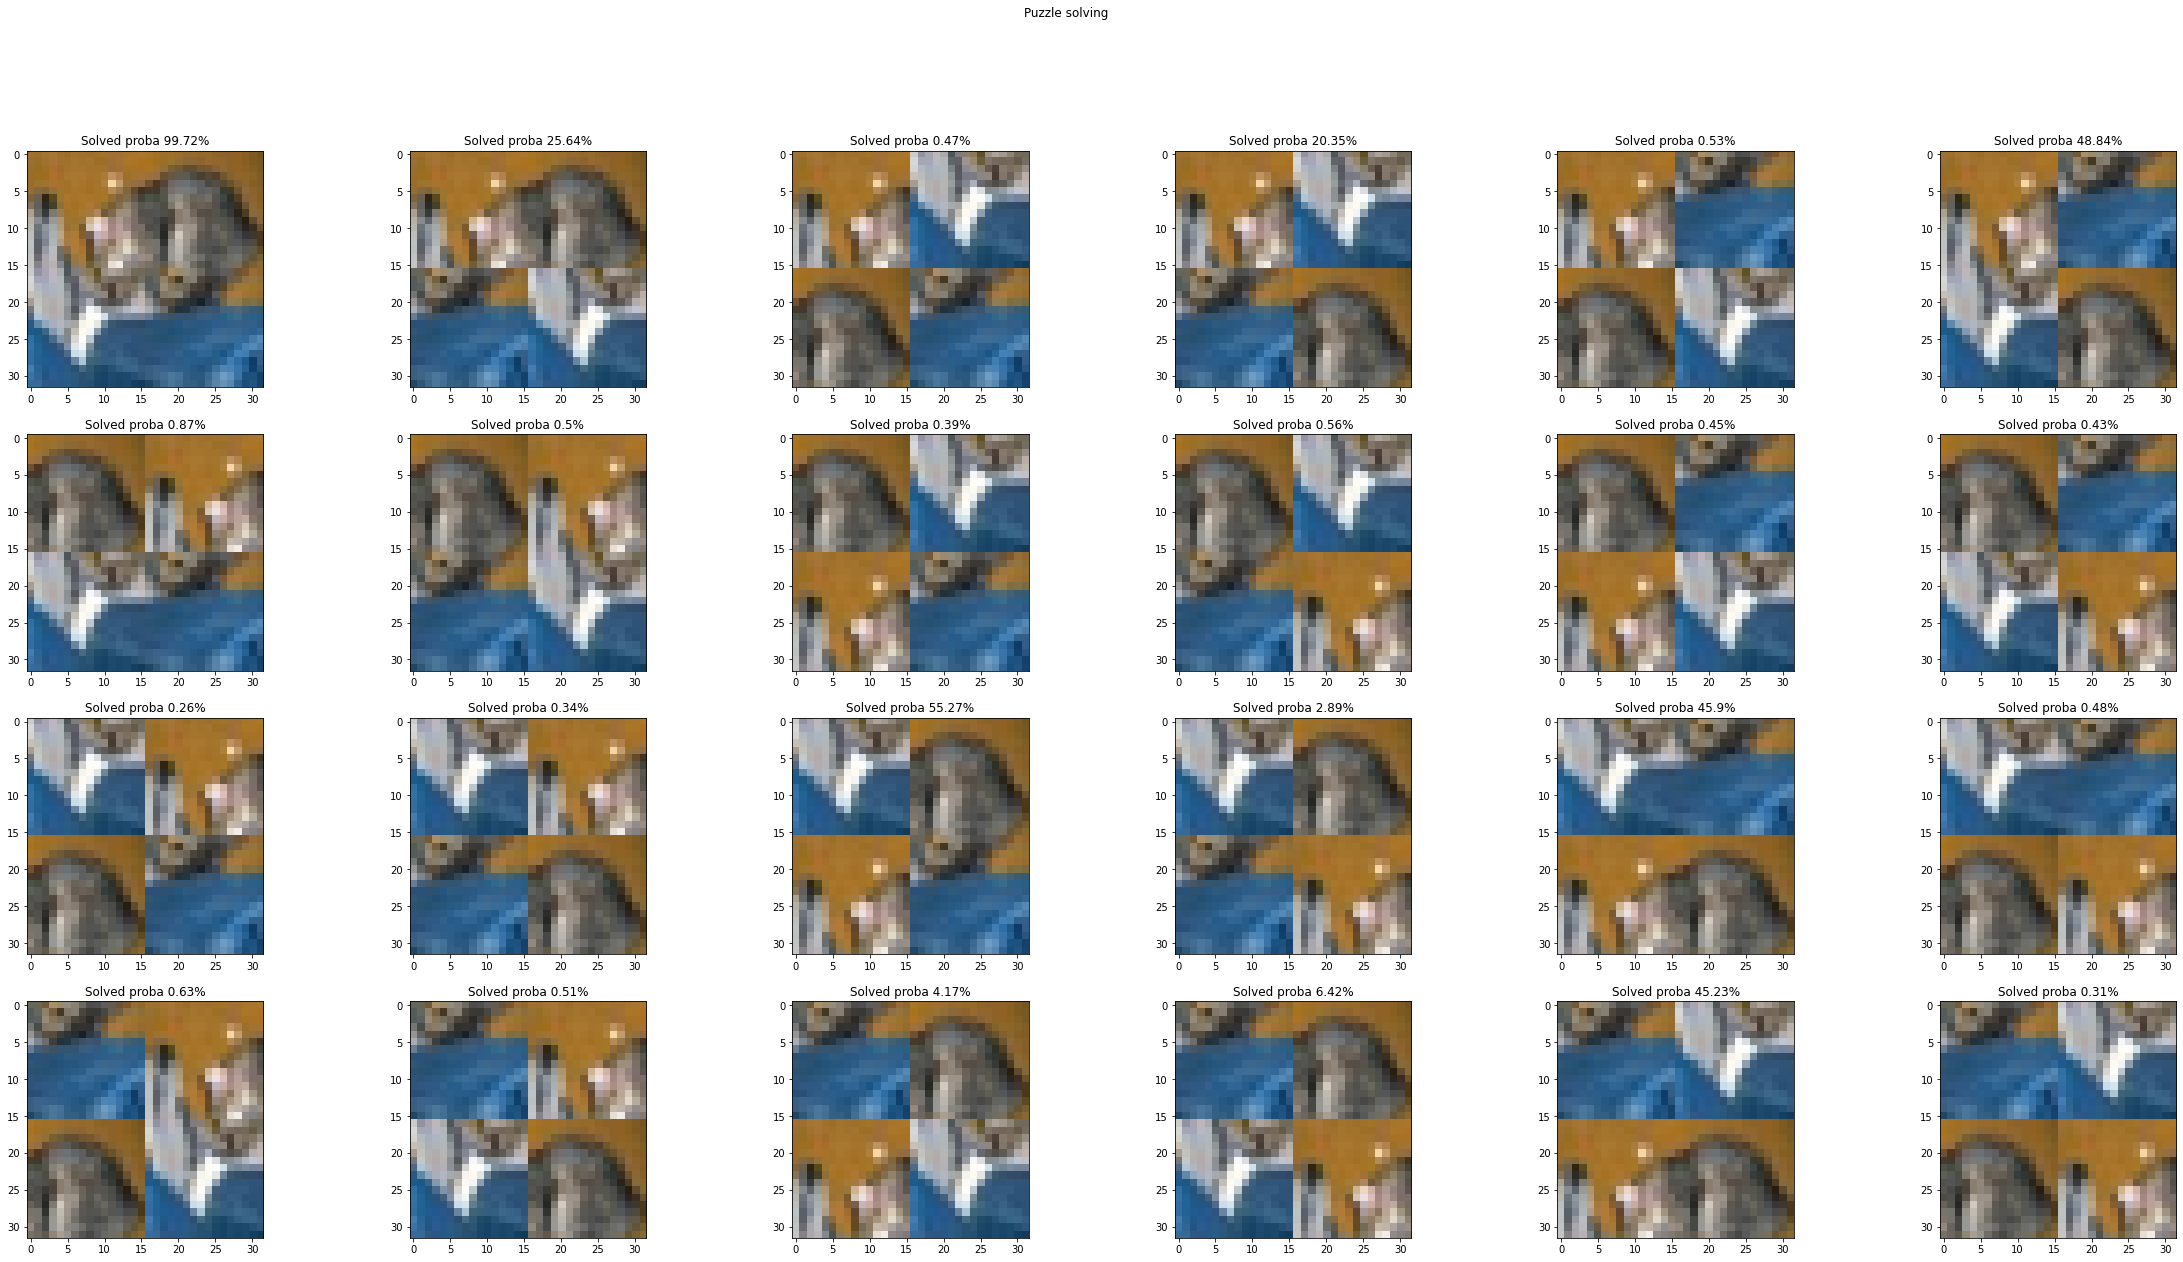

In [ ]:
def main(train_dataset, test_dataset):
    # device calcule on CPU or GPU
    device        = torch.device('cuda') # here on GPU
    # number of time we will loop over the entire dataset
    epochs        = 5
    # size of image groups
    batch_size    = 64
    # learning rate for the gradient_descent
    learning_rate = 5e-4
    # number of tile on one axis
    n_tile = 2
    # we initialize the model
    model         = CIFARTILE(n_tile)
    # we put it on device
    model         = model.to(device)
    # criterion class for loss calcul
    criterion     = nn.NLLLoss()
    # optimizer class which will update model parameters and learning rate
    optimizer     = optim.Adam(params = model.parameters(), lr = learning_rate)
    # train model
    train(model, device, criterion, optimizer, train_dataset, test_dataset, epochs, batch_size)
    # visualize training result
    show_model_output(model,device,n_tile)

main(train_dataset, test_dataset)

# Level 2


## Random Tile Shuffler
Random Tile shuffler for CIFAR10 images. It allows us to split and shuffle tiles of an image.  

In [ ]:
class RandomTileShuffler(): 
    # class initialization
    def __init__(self, n_tile, p = .8):  
        # number of tile on one axis
        self.n_tile = n_tile 
        # probability of having the image shuffled on call
        self.p = p 

    # Split the input image 
    def __split_image(self,image): 
      # retrieve image shape 
      shape = image.shape  # shape[3,32,32]  
      # split to get n_tile horizontal tiles
      image = image.reshape(3,self.n_tile,-1,shape[1]) # shape[3,n_tile,32/n_tile,32] 
      # transpose dim 2 and 3 for vertical tiles
      image = image.transpose(2,3) # shape[3,n_tile,32,32/n_tile]
      # split to get n_tile * n_tile tiles and return the splitted image
      return image.reshape(3, self.n_tile, self.n_tile, shape[1]//self.n_tile, -1) # shape[3,n_tile,n_tile,32/n_tile,32/n_tile] 

    # Unsplit the input image
    def __unsplit_image(self,image): # shape[3,n_tile,n_tile,16,16]
      # unsplit vertical tile
      image = image.reshape(3,self.n_tile,image.shape[2]*image.shape[3],-1) # shape[3,n_tile,32,32/n_tile] 
      # transpose dim 2 and 3 for horizontal tiles
      image = image.transpose(2,3)  # shape[3,n_tile,32/n_tile,32] 
      # unsplit horizontal tiles and return the image
      return image.reshape(3,32,32) # shape[3,32,32] 

    # Shuffle the image
    def __shuffle_image(self,image) : 
      #permutations list
      permutations = np.array(list(itertools.permutations(range(self.n_tile*self.n_tile))))
      #index permutation avoiding the first permutation which is not shuffled
      index = random.randint(1,permutations.shape[0]-1)
      #return the shuffled image
      return self.shuffle(image,permutations[index],index)

    # Shuffle image depending on array positions
    def shuffle(self,image,perm_pos,index):
      # split the image
      splitted_image = self.__split_image(image)
      # copy the splitted_image
      splitted_image_copy = splitted_image.detach().clone()
      # for each position
      for i in range(len(perm_pos)) :
        x,y = i//self.n_tile,i%self.n_tile # x and y position on image
        x2,y2 = perm_pos[i]//self.n_tile,perm_pos[i]%self.n_tile # x2 and y2 position from random tiles positons
        # swap on RGB channels
        for c in range(3) :
          splitted_image[c][x][y],splitted_image_copy[c][x2][y2]=splitted_image_copy[c][x2][y2].clone().detach(),splitted_image[c][x][y].clone().detach()# swap each tile
      return self.__unsplit_image(splitted_image),index  # unsplit the image to retrieve new image

    # resolve shuffled image from perm_pos tensor
    def resolve(self,image,perm_pos):
      # split the image
      splitted_image = self.__split_image(image)
      # copy the splitted_image
      splitted_image_copy = splitted_image.detach().clone()
      # for each position
      for i in range(len(perm_pos)) :
        x,y = perm_pos[i]//self.n_tile,perm_pos[i]%self.n_tile # x and y position on image
        x2,y2 = i//self.n_tile,i%self.n_tile # x2 and y2 position from random tiles positons
        # swap on RGB channels
        for c in range(3) :
          splitted_image[c][x][y],splitted_image_copy[c][x2][y2]=splitted_image_copy[c][x2][y2].clone().detach(),splitted_image[c][x][y].clone().detach()# swap each tile
      return self.__unsplit_image(splitted_image)  # unsplit the image to retrieve proper image

    # Decide to shuffle or not
    def __call__(self, image):
        # If we do not shuffle, we return 0 and the raw image
        if torch.rand(1) >= self.p: 
            return image, 0
        # Else we return the shuffled image and the index of the permutation
        return self.__shuffle_image(image)

## Data loading
Load CIFAR10 dataset for model training and testing

In [ ]:
#transformations applied to each images during data loading
cifar_transform = transforms.Compose(
    [
     # flip the image horizontally or not
     transforms.RandomHorizontalFlip(),
     # load image as a tensor
     transforms.ToTensor(),
     # Shuffle the image or not
     RandomTileShuffler(2),
    ]
) 

#load data for model training
train_dataset = datasets.CIFAR10(
    root      = './data',
    train     = True,
    download  = True,
    transform = cifar_transform # we call the transformations
)

#load data for model testing
test_dataset = datasets.CIFAR10(
    root      = './data',
    train     = False,
    download  = True,
    transform = cifar_transform # we call the transformations
)

Files already downloaded and verified
Files already downloaded and verified


## Model class
Model class to solve our tile problem.
<br>
We use CNN architecture which basically use convolutional, max pooling and linear layers to process data.
We use convolution layer to detect features in the image then we use max pooling layer to reduce filters size. After that we use linear layer to reduce data size/dimension to retrieve the exact number of class we want. 

In [ ]:
class CIFARTILEPERM(nn.Module): # inherit from base neural class nn.Module 
    #initialize model
    def __init__(self,n_tile):
        #call parent constructor
        super().__init__()
        # convolutional layer which creates 32 filters
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 32,
            # kernel size applied to each pixel
            kernel_size = (3, 3),
            # avoid 1 pixel on border
            padding = 1
        )
        # drop values with probabilty 0.6
        self.dropout1 = nn.Dropout(
          p = 0.6
        )
        # convolutional layer which creates 64 filters
        self.conv_2 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            # kernel size applied to each pixel
            kernel_size = (3, 3),
            # avoid 1 pixel on border
            padding = 1
        )
        # drop values with probabilty 0.6
        self.dropout2 = nn.Dropout(
          p = 0.6
        )
        # linear layer which compute 64*8*8 features to 512 features
        self.lin_1 = nn.Linear(
            in_features = 64 * 8 * 8, 
            out_features = 512
        )
        # linear layer which compute 512 features to (n_tile*n_tile)! features
        self.lin_2 = nn.Linear(
            in_features = 512, 
            out_features = factorial(n_tile*n_tile)
        )

    # process batch
    def forward(self, x):    
        # we apply conv_1 on data         
        x = self.conv_1(x)  # shape[batch_size,32,32,32]  
        # we drop some values
        x = self.dropout1(x)     
        # we activate neurons to avoid linearity 
        x = F.relu(x)          
        # we reduce the filters size by max pooling   
        x = F.max_pool2d(x, (2, 2)) # shape[batch_size, 32, 16, 16]
        # we apply conv_2 on data 
        x = self.conv_2(x)          # shape[batch_size, 64, 16, 16]
        # we drop some values
        x = self.dropout2(x)
        # we activate neurons to avoid linearity         
        x = F.relu(x)    
        # we reduce the filters size by max pooling      
        x = F.max_pool2d(x, (2, 2)) # shape[batch_size, 64, 8, 8]
        # we flatten batch in order to apply linear Regression
        x = torch.flatten(x, start_dim = 1) # shape[batch_size,32*8*8]
        # we apply lin_1 on data
        x = self.lin_1(x) # shape[batch_size,508]
        # we activate neurons to avoid linearity       
        x = F.relu(x)     
        # we apply lin_2 on data        
        x = self.lin_2(x) # shape[batch_size,factorial(n_tile*n_tile)]   
        # we calculate log probabilities for prediction
        x = torch.log_softmax(x, dim = 1)  

        return x

## Model prediction visualization
In order to understand if our model is doing well, we try to visualize model prediction

In [ ]:
def show_model_output(model,device,n_tile,) :
    # load CIFAR10 dataset with transform that only perform ToTensor()
    test_dataset = datasets.CIFAR10(
      root      = './data',
      train     = False,
      download  = True,
      transform = transforms.Compose([transforms.ToTensor()])
    )
    # retrieve 10 first images
    imgs = [ test_dataset[i][0] for i in range(10)]
    # create tile shuffler
    shuffler = RandomTileShuffler(n_tile,1)
    # shuffle images
    shuffled_imgs = [ shuffler(img.detach().clone())[0] for img in imgs]
    # we transfer these images in a batch
    img_batch = torch.stack(shuffled_imgs).to(device)
    # we predict on image batch
    y_pred = model(img_batch)
    # visualize image batch predictions
    show_predictions(img_batch.cpu(),y_pred.cpu(),n_tile,shuffler)

In [ ]:
def show_predictions(X,y_pred,n_tile,shuffler):
  # create figure of 10 rows and 3 columns
  fig, ax = plt.subplots(nrows=X.shape[0], ncols=3, figsize=(25,40))
  # get the permutations list
  permutations = np.array(list(itertools.permutations(range(n_tile*n_tile))))
  # join permutations elements to string   
  x = [ ''.join(l) for l in permutations.astype(str)]
  # for each img
  for i,img in enumerate(X) :
    # predict y for the image
    y = F.softmax(y_pred[i:i+1],dim=1)[0] * 100
    # convert to numpy array
    y = y.detach().numpy()
    # resolve image base on y prediction
    img_resolved = shuffler.resolve(img.clone().detach(),permutations[y.argmax()]).transpose(0,2).transpose(0, 1)
    # get the right shape for imshow
    img = img.transpose(0,2).transpose(0, 1)
    # print shuffled image
    ax[i,0].imshow(img)
    # print permutations histogram
    ax[i,1].set_xticklabels(x,rotation=45)
    ax[i,1].bar(x,y)
    # print resolved image
    ax[i,2].imshow(img_resolved)

## Main function
In order to train our model we write a main function in which we will specify hyperparameters

Initial accuracy 3.438%
[  0][   0] -> 19.417% training accuracy 20.167% test accuracy
[  0][ 250] -> 32.125% training accuracy 31.333% test accuracy
[  0][ 500] -> 48.875% training accuracy 50.562% test accuracy
[  0][ 750] -> 55.375% training accuracy 56.750% test accuracy
[  0][1000] -> 60.229% training accuracy 61.792% test accuracy
[  0][1250] -> 62.938% training accuracy 61.521% test accuracy
[  0][1500] -> 64.958% training accuracy 63.938% test accuracy
  0 -> 65.532% training accuracy 65.460% test accuracy
[  1][   0] -> 65.271% training accuracy 65.250% test accuracy
[  1][ 250] -> 66.125% training accuracy 65.333% test accuracy
[  1][ 500] -> 67.688% training accuracy 67.917% test accuracy
[  1][ 750] -> 68.104% training accuracy 68.708% test accuracy
[  1][1000] -> 69.104% training accuracy 69.312% test accuracy
[  1][1250] -> 70.521% training accuracy 69.938% test accuracy
[  1][1500] -> 72.396% training accuracy 70.938% test accuracy
[  2][   0] -> 71.938% training accurac

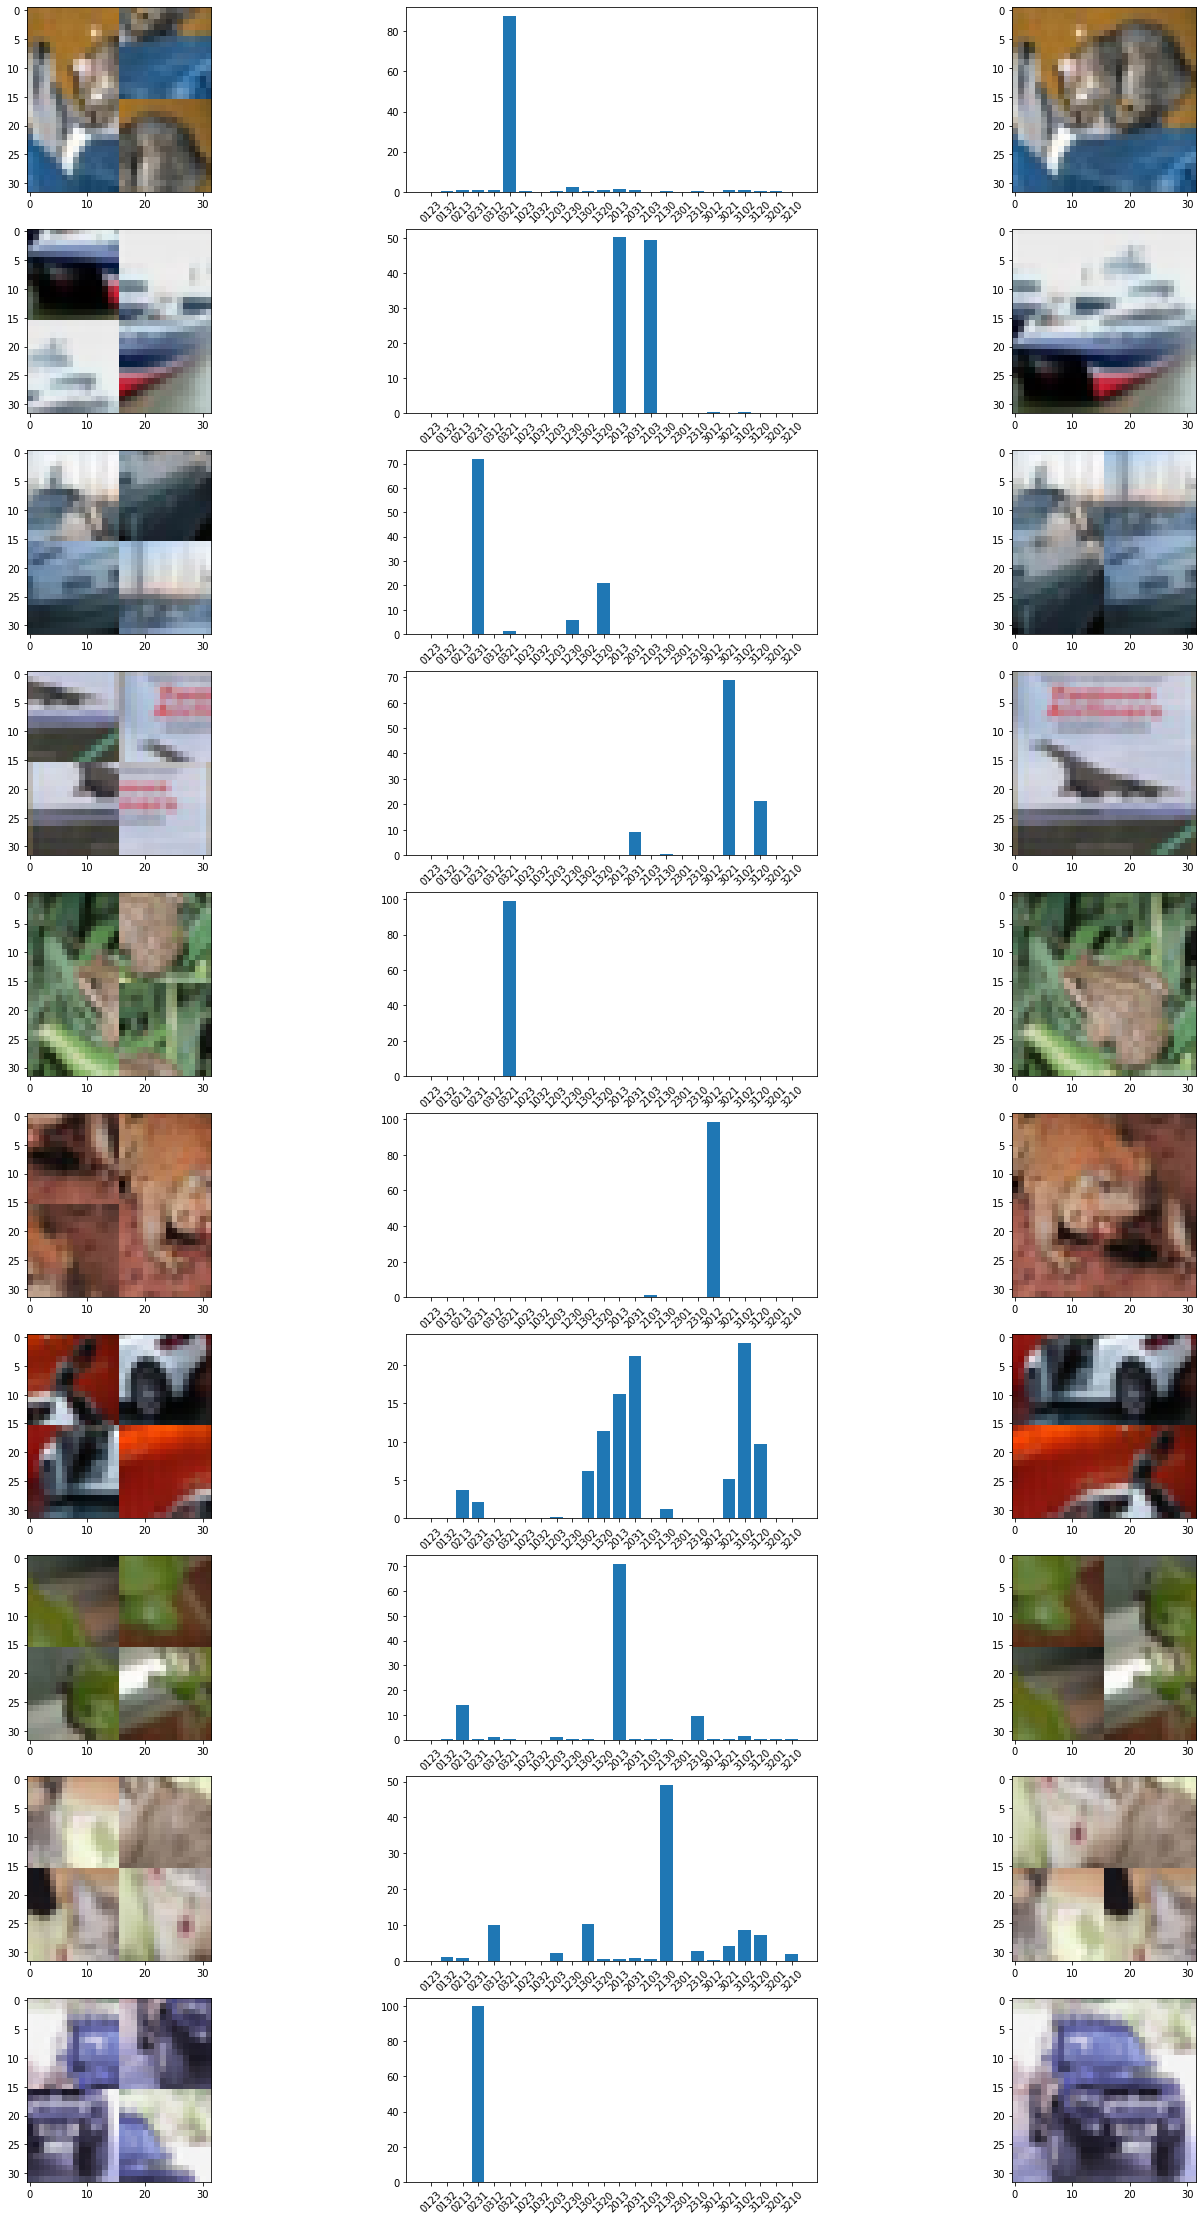

In [ ]:
def main(train_dataset, test_dataset):
    # device calcule on CPU or GPU
    device        = torch.device('cuda') # here on GPU
    # number of time we will loop over the entire dataset
    epochs        = 8
    # size of image groups
    batch_size    = 32
    # learning rate for the gradient_descent
    learning_rate = 5e-4
    # number of tile on one axis
    n_tile = 2
    # we initialize the model
    model         = CIFARTILEPERM(n_tile)
    # we put it on device
    model         = model.to(device)
    # criterion class for loss calcul
    criterion     = nn.NLLLoss()
    # optimizer class which will update model parameters and learning rate
    optimizer     = optim.Adam(params = model.parameters(), lr = learning_rate)
    # train model
    train(model, device, criterion, optimizer, train_dataset, test_dataset, epochs, batch_size)
    # visualize training result
    show_model_output(model,device,n_tile)

main(train_dataset, test_dataset)